In [1]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
# prevent exponentional memory growth
physical_devices = tf.config.list_logical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [ ]:
# two build functions one for image and one for dataset
import gdown

url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output, quiet=False)
gdown.extractall('data.zip')

In [3]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean),tf.float32)/std


In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890"]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'](size=40)


In [6]:
def load_alignments(path:str) -> List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [7]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames,alignments

In [8]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [9]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [10]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

tf.Tensor(
[[[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.19734782]
  [0.07893913]]

 [[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.07893913]
  [0.03946957]]

 [[1.4209043 ]
  [1.4209043 ]
  [1.3814348 ]
  ...
  [0.07893913]
  [0.07893913]
  [0.07893913]]

 ...

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.94633   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]], shape=(46, 140, 1), dtype=float32)


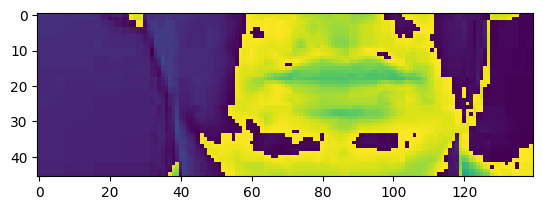

In [11]:
plt.imshow(frames[0])
print(frames[0])

In [12]:
bytes.decode(tf.strings.reduce_join([x for x in num_to_char(alignments)]).numpy())

'binblueatlsixnow'

In [13]:
# helps use to get data from file name
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path],(tf.float32,tf.int64))
    return result

In [14]:
#make a datapipeline

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [15]:
frames, alignments = data.as_numpy_iterator().next()

In [16]:
alignments

array([[16, 12,  1,  3,  5,  0, 18,  5,  4,  0,  9, 14,  0, 16,  0, 20,
        23, 15,  0, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20,  0, 18,  5,  4,  0,  9, 14,  0,  8,  0, 26,  5, 18,
        15,  0, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [17]:
len(frames)

2

In [18]:
test = data.as_numpy_iterator()

In [19]:
val = test.next(); 
val[0][1]

array([[[[ 1.4027374 ],
         [ 1.4027374 ],
         [ 1.4027374 ],
         ...,
         [ 0.04125698],
         [ 0.04125698],
         [ 0.04125698]],

        [[ 1.4027374 ],
         [ 1.4027374 ],
         [ 1.4027374 ],
         ...,
         [ 0.04125698],
         [ 0.04125698],
         [ 0.04125698]],

        [[ 1.3202235 ],
         [ 1.3202235 ],
         [ 1.3202235 ],
         ...,
         [ 0.04125698],
         [ 0.04125698],
         [ 0.04125698]],

        ...,

        [[ 1.0314245 ],
         [ 1.0314245 ],
         [ 0.99016756],
         ...,
         [10.314245  ],
         [10.272988  ],
         [10.272988  ]],

        [[ 1.0314245 ],
         [ 1.0314245 ],
         [ 0.99016756],
         ...,
         [10.272988  ],
         [10.231731  ],
         [10.231731  ]],

        [[ 1.0314245 ],
         [ 1.0314245 ],
         [ 0.99016756],
         ...,
         [10.272988  ],
         [10.231731  ],
         [10.231731  ]]],


       [[[ 1.3614805 ],


In [20]:
imageio.v3.imwrite('./animation.gif',val[0][0])

TypeError: Cannot handle this data type: (1, 1, 1), <f4

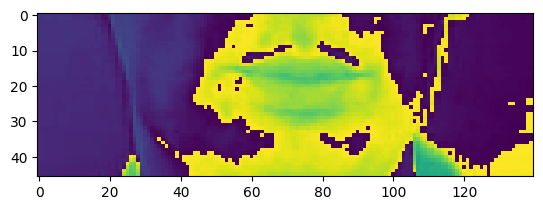

In [21]:
plt.imshow(val[0][0][30])

In [22]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'setgreenbycnineagain'>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional, MaxPool3D,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [24]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal',activation='softmax'))

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [26]:
# test prediction
yhat = model.predict(val[0])

1/1 [==============================] - 20s 20s/step


In [27]:
bytes.decode(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]]).numpy())

'jjjjjoooooooooooooooooooooooooooooooooooooocccccccccccccccccccccccccccccccc'

In [28]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [29]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len,1),dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1),dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss

In [30]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self,dataset):
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None):
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat,[75,75],greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [32]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [34]:
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(data)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [37]:
import gdown
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=cbc4e388-fad8-49e7-aa4d-e419788014a0
To: c:\Users\Aaron\OneDrive\Desktop\github\lipReadMLModel\checkpoints.zip
100%|██████████| 94.5M/94.5M [01:01<00:00, 1.53MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [40]:
model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat,input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[0]]

In [ ]:
print('~'*100,'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]